In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import arnet
from arnet.ar_net_legacy import init_ar_learner

%matplotlib inline

In [2]:
# data
DIR = os.path.dirname(os.path.abspath(''))
data_path = os.path.join(DIR, 'ar_data')
results_path = os.path.join(DIR, 'results')
models_path = os.path.join(DIR, 'models')
if not os.path.exists(results_path): 
    os.makedirs(results_path)        
if not os.path.exists(models_path): 
    os.makedirs(models_path)
    
data_names = ['ar_3_ma_0_noise_0.100_len_10000'] 

In [3]:
# hyperparameters
save = True
sparsity = 0.5  # guesstimate
ar_order = 10  # guesstimate

n_epoch = 10
valid_p = 0.1

fitting: ar_3_ma_0_noise_0.100_len_10000


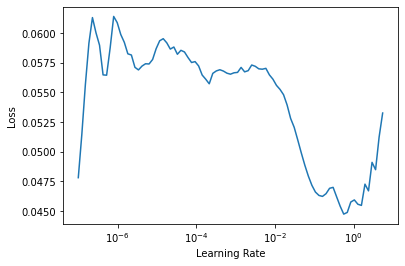

lr at minimum: 0.05623413324356079; steeptes lr: 0.020417379215359688


epoch,train_loss,valid_loss,mae,time
0,0.020248,0.013306,0.091418,00:01
1,0.010328,0.010245,0.080722,00:01
2,0.010258,0.010097,0.080104,00:01
3,0.010552,0.010240,0.080945,00:01
4,0.010190,0.010257,0.080975,00:01
5,0.010604,0.010100,0.080252,00:01
6,0.010374,0.010058,0.079831,00:01
7,0.010370,0.010076,0.079970,00:01
8,0.010277,0.010079,0.079972,00:01
9,0.010468,0.010070,0.079924,00:01


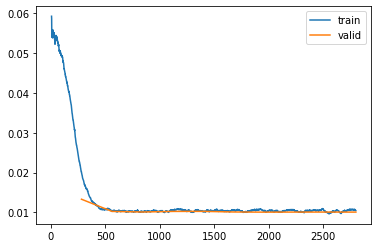

In [4]:
# fit and collect AR coefficients
coeff_list = []
for name in data_names:
    print("fitting: {}".format(name))
    df = pd.read_csv(os.path.join(data_path, name + '.csv'), header=None, index_col=False)
    # Init Model
    learn = init_ar_learner(
        series=df,
        ar_order=ar_order,
        n_forecasts=1,
        valid_p=valid_p,
        sparsity=sparsity,
        train_bs=32,
        valid_bs=1024,
        verbose=False,
    )
    # find Learning Rate
    lr_at_min, lr_steep = learn.lr_find(start_lr=1e-7, end_lr=100, num_it=100, show_plot=True)
    plt.show()
    print("lr at minimum: {}; steeptes lr: {}".format(lr_at_min, lr_steep))
    lr_max = lr_at_min/10

    # Run Model
    learn.fit_one_cycle(n_epoch=n_epoch, lr_max=lr_max)
    learn.recorder.plot_loss()
    plt.show()
    # record Coeff
    coeff = arnet.coeff_from_model(learn.model)    
    coeff_list.append({"name": name, "coeff": coeff[0]})
df_coeff = pd.DataFrame(coeff_list)


In [5]:
df_coeff

,name,coeff
0,ar_3_ma_0_noise_0.100_len_10000,"[0.19604042, 0.2887145, -0.4777012, 0.0003959917, 1.7987082e-05, 3.091372e-05, 0.00032146755, -1.1136071e-05, 2.8788853e-07, -2.827955e-06]"


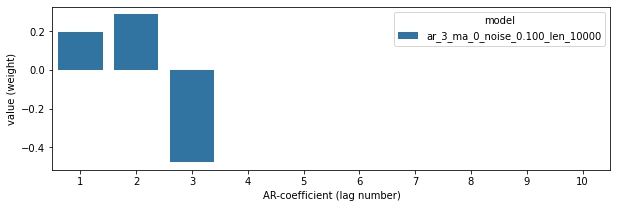

In [6]:
if save:
    df_coeff.to_csv(
        os.path.join(results_path, "coeff_ar-{}_spar-{}.csv".format(ar_order, sparsity)),
        index=False,
    )
    for index, row in df_coeff.iterrows():
        arnet.plot_weights(
            ar_val=ar_order,
            weights=row["coeff"],
            model_name=row["name"],
            save=True,
            savedir=results_path,
            figsize=(10,3),
        )